# A project done by : 

* Rayhane Talbi
    
Python 3 is used for this project

This Lab aims at implementing Machine Learning techniques for classifying text data.
We decided to use KNN and Random Forest Algorithms in order to perform text classification on tweets.
The tweets can be labeled into three categories :
* Hateful tweets
* Offensive tweets
* None of them


# Import libraries

* Pandas for Data Analysis
* Numpy for manipulating matrices and arrays
* Nltk for text processing, tokenization, lemmatization, stemming and classification
* Re for using regular expressions
* String for dealing with text data
* Sklearn for Machine Learning and Algorithms implementation
* Matplotlib and Seaborn for plotting and Data Visualization

In [97]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re
import string
import sklearn
from sklearn import metrics, neighbors
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import make_pipeline, Pipeline
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
%matplotlib inline

# Import a public dataset

The public Dataset we chose can be found on this Github Link : 
https://github.com/t-davidson/hate-speech-and-offensive-language/tree/master/data.
The data is stored as a CSV file and as a pickled pandas dataframe.
We chose to download the CSV file, read it using the pandas read_csv function and store it into a dataframe of our convenience.

In [40]:
# read dataset csv file 
df = pd.read_csv("labeled_data.csv")

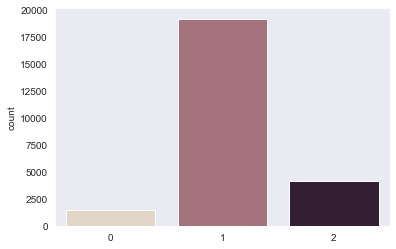

In [41]:
# plot the data distribution 
sns.barplot(x=[0,1,2], y=df.groupby("class").count()['count'],  palette="ch:.25")
sns.set_style('dark')
plt.show()

=> Our Dataset is imbalanced since the second category include more samples than the two others. We expect this to be a complicating factor for further machine learning analysis and can make data exploration more challenging for us.

# Some Dataset cleaning

In [42]:
# delete line with nan (to be sure)
df = df.dropna(how='any')
# remove first column (because it is the same as the index column)
df = df.drop(df.columns[0], axis=1)
# specify class names and define the categories we want to classify our text into
class_names = ["Hate Speech","Offensive Language","Neither"]
# remove count and classes columns from dataframe
df = df.drop(columns=["count","hate_speech","offensive_language","neither"],axis=1)
# add category column to dataframe
df["Category"] = df["class"].map({0:"Hate Speech",1:"Offensive Language",2:"Neither"})

In [43]:
# check the number of rows and columns in the dataframe 
# we have 1 input feature (text) and 1 target output (class number)
df.shape

(24783, 3)

In [45]:
# show examples of data (the first 10 lines for instance)
df.head(10)

,class,tweet,Category
0,2,!!! RT @mayasolovely: As a woman you shouldn't...,Neither
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,Offensive Language
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,Offensive Language
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,Offensive Language
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,Offensive Language
5,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just...",Offensive Language
6,1,"!!!!!!""@__BrighterDays: I can not just sit up ...",Offensive Language
7,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...,Offensive Language
8,1,""" &amp; you might not get ya bitch back &amp; ...",Offensive Language
9,1,""" @rhythmixx_ :hobbies include: fighting Maria...",Offensive Language


In [46]:
# show number of tweets per class
df.groupby("class").count()

,tweet,Category
class,,
0,1430,1430
1,19190,19190
2,4163,4163


# Perform two different preprocessing 

In [47]:
# download the list of english stopwords
stop_words = set(stopwords.words('english'))
# add some stopwords to the previous list for analysis improvment
stop_words = stop_words.union({'arent', 'couldnt', 'didnt', 'doesnt', 'dont', 'hadnt', 'hasnt', 'havent', 'isnt', 'mightnt', 'mustnt', 'neednt', 'shant', 'shes', 'shouldnt', 'shouldve', 'thatll', 'wasnt', 'werent', 'wont', 'wouldnt', 'youd', 'youll', 'youre', 'youve'})
# download the lemmatization dictionnary of words
lemmatizer = WordNetLemmatizer()
# download the English Stemmer
stemmer =PorterStemmer()

In [48]:
def preprocess1(text):
    # lowercase text, remove URLs, RT, Users mentions, Emojis and numbers
    # Perform tokenization and stemming
    text = text.lower()
    text = re.sub(r'&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});','', text) #Emojis
    text = re.sub(r'(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)', '',text)
    text = re.sub(r'@[\w\-]+', '',text)
    text = re.sub(r"rt[\s]+", "", text)
    text = (re.compile('[^a-z ]')).sub('',text)
    tokens = nltk.word_tokenize(text)
    text_stem = [stemmer.stem(word) for word in tokens if word not in stop_words]
    text_stem = " ".join([t for t in text_stem])
    return text_stem

In [49]:
def preprocess2(text):
    # lowercase text, remove URLs, RT, Users mentions, Emojis and numbers
    # Perform tokenization and lemmatization
    text = text.lower()
    text = re.sub(r'@(\d|[a-zA-Z])+', '',text)
    text = re.sub(r'&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});','', text) #Emojis
    text = re.sub(r'(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)', '',text)
    text = re.sub(r'@[\w\-]+', '',text)
    text = re.sub(r"rt[\s]+", "", text)
    text = (re.compile('[^a-z ]')).sub('',text)
    tokens = nltk.word_tokenize(text)
    text_lem = [lemmatizer.lemmatize(word) for word in tokens]
    text_lem = " ".join([t for t in text_lem])
    return text_lem

In [50]:
# for simplicity, start by applying the first preprocessing tasks 
df["tweet"] = df["tweet"].apply(preprocess1)

# Split dataset

In [51]:
# create a dataframe X for input feature and a dataframe Y for the target label column
X = df["tweet"]
Y = df["class"]

In [52]:
X

0           woman complain clean hous man alway take trash
1         boy dat coldtyga dwn bad cuffin dat hoe st place
2               dawg ever fuck bitch stato cri confus shit
3                                         look like tranni
4           shit hear might true might faker bitch told ya
                               ...                        
24778    you muthafin lie right tl trash mine bibl scri...
24779         gone broke wrong heababi drove redneck crazi
24780    young buck wan na eat dat nigguh like aint fuc...
24781                       youu got wild bitch tellin lie
24782    ruffl ntac eileen dahlia beauti color combin p...
Name: tweet, Length: 24783, dtype: object

In [53]:
Y

0        2
1        1
2        1
3        1
4        1
        ..
24778    1
24779    2
24780    1
24781    1
24782    2
Name: class, Length: 24783, dtype: int64

In [54]:
# split the dataset into train and test data
# We’ll load the final training data into X_train and labels into Y_train
# Consider only 30% of data for testing and 70% of them for training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)
# X_train : Feature training set ; Y_train : Label traning set ; X_test : Feature testing set ; Y_test : Label testing set

# Implement Random Forest algorithm

In [91]:
# make a list of all the tweets
tweets = []
for line in df['tweet']:
    tweets.append("".join(line))

In [93]:
# create a td-idf vectorizer and fit it on the data
tfidfconverter = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X_tfidf = tfidfconverter.fit_transform(tweets).toarray()

In [94]:
# create a Random-Forest classifier
clf = RandomForestClassifier(n_estimators = 1000,max_depth=5, random_state=0)
cv_results =cross_val_score(clf, X_tfidf, df['class'],scoring='recall_micro', cv = 3)

In [95]:
# get the average of scores
np.mean(cv_results)

0.7743211072105879

In [96]:
# get the predictions on the test data
y_pred = cross_val_predict(clf,X_tfidf, df['class'], cv=5)

In [98]:
# get the confusion matrix
conf_mat = confusion_matrix(df['class'], y_pred)

In [101]:
# get the metrics values
print("Confusion matrix :\n")
print(confusion_matrix(df['class'],y_pred))
print("\nClassification report :\n")
print(classification_report(df['class'],y_pred))
print("Accuracy:")
print(metrics.accuracy_score(df['class'], y_pred))

Confusion matrix :

[[    0  1430     0]
 [    0 19190     0]
 [    0  4163     0]]

Classification report :

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1430
           1       0.77      1.00      0.87     19190
           2       0.00      0.00      0.00      4163

    accuracy                           0.77     24783
   macro avg       0.26      0.33      0.29     24783
weighted avg       0.60      0.77      0.68     24783

Accuracy:
0.7743211072105879


# Implement KNN Algorithm 

We need numerical representation of words to feed them into our K-NN algorithm in order to compute distances and make predictions.
To do so, we had to opt for a numerical representation of text using bag of words with tf-idf(Term Frequency - Inverse document frequency).

In [63]:
# create a bag of words vectorizer to transform text data into numerical data
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

In [64]:
# generating feature vectors of token counts and then transform into tf-idf representation
# make us of the tf-idf method
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [65]:
# create a KNN classifier with a numer of neighbours chosen for simplicity as 5
knn = KNeighborsClassifier(n_neighbors=5)

In [66]:
# create a pipeline to add the vectorizers, the transformer and the classifier all in a one compound classifier
text_clf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', knn)])
# train the model : we assign the class variables to training data => knn uses lazy training which means that computation is differed till computation
text_clf.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,

# Evaluate the model : Accuracy, Precision, Recall, F1 score, Confusion matrix and K values

In [67]:
# Predict the output of our input text by using the classifier we just trained
predictions = text_clf.predict(X_test)

In [75]:
# get the accuracy scores
acc = metrics.accuracy_score(Y_test, predictions)
print('KNN with TFIDF accuracy = ' + str(acc * 100) + '%')

KNN with TFIDF accuracy = 81.31809011432414%


In [69]:
# print the classification report 
print(metrics.classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.39      0.18      0.24       429
           1       0.83      0.97      0.89      5757
           2       0.80      0.33      0.47      1249

    accuracy                           0.81      7435
   macro avg       0.67      0.49      0.53      7435
weighted avg       0.80      0.81      0.78      7435



In [70]:
# plot the confusion matrix
print(metrics.confusion_matrix(Y_test, predictions))

[[  76  346    7]
 [ 100 5559   98]
 [  19  819  411]]


In [71]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot
    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix
    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']
    title:        the text to display at the top of the matrix
    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues
    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

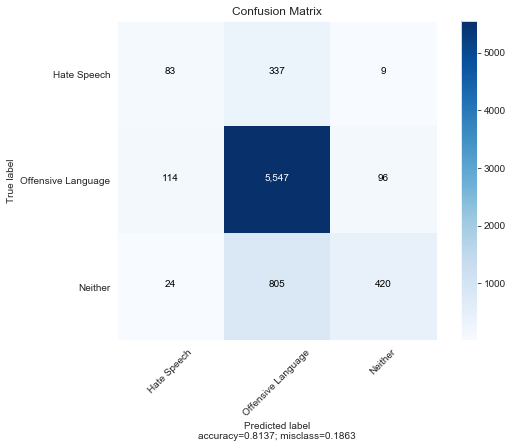

In [72]:
# plot the confusion matrix of preprocessing 1
plot_confusion_matrix(np.array(
[[  83,  337,    9],
 [ 114, 5547,   96],
 [  24,  805,  420]]),normalize    = False,
                      target_names = ['Hate Speech', 'Offensive Language', 'Neither'],
                      title        = "Confusion Matrix")

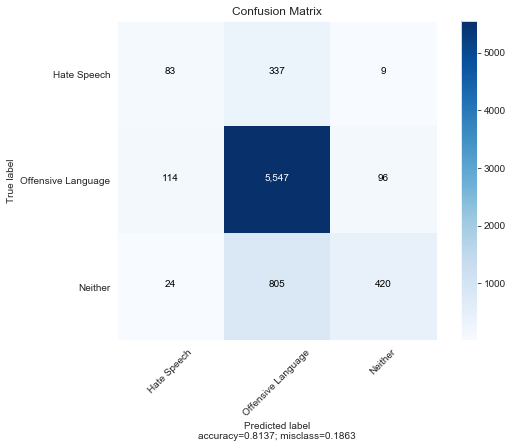

In [73]:
# plot the confusion matrix of preprocessing 2
plot_confusion_matrix(np.array(
[[  83,  337,    9],
 [ 114, 5547,   96],
 [  24,  805,  420]]),normalize    = False,
                      target_names = ['Hate Speech', 'Offensive Language', 'Neither'],
                      title        = "Confusion Matrix")

# Perform Cross-Validation

In k-fold cross-validation, the original sample is randomly partitioned into c equal size subsamples.
Here, we choose a value of c=5 and therefore we iterate 5 times over the entire dataset.

In [76]:
# Use k-fold cross-validation to train the model
cv_scores = cross_val_score(text_clf, X, Y, cv=5, scoring="accuracy")

In [77]:
cv_scores

array([0.79745814, 0.81057091, 0.81299173, 0.8220339 , 0.81255044])

In [78]:
# print the average of scores
cv_scores.mean()

0.8111210241816508

In [79]:
# print the F1-score
f1_scores = cross_val_score(text_clf, X, Y, cv=5, scoring='f1_macro')

In [80]:
f1_scores

array([0.49284624, 0.5890751 , 0.53291744, 0.52183074, 0.5262936 ])

In [81]:
# print the average of F1 scores
f1_scores.mean()

0.5325926224918227

# Find the optimal value of K for which the model has the best performance


In [82]:
# iterate of different values of K (here for example : from 1 to 15)
# other optimisation algorithms like GrisearchCV can be implemented for the same purpose
k_range = range(1, 15)
# list of scores from k_range
k_scores = []
# 1. we will loop through reasonable values of k
for k in k_range:
    # 2. run KNeighborsClassifier with k neighbours and generate a tf-idf pipeline
    knn_ = KNeighborsClassifier(n_neighbors=k)
    text_clf_ = Pipeline([('tfidf', TfidfVectorizer()), ('clf', knn_)])
    # 3. obtain cross_val_score for KNeighborsClassifier with k neighbours
    scores = cross_val_score(text_clf_, X, Y, cv=10, scoring='accuracy')
    # 4. append mean of scores for k neighbors to k_scores list
    k_scores.append(scores.mean())
# get the value of K for which we have the best accuracy score
print(max(k_scores))

0.8162468203449735


<Figure size 432x288 with 0 Axes>

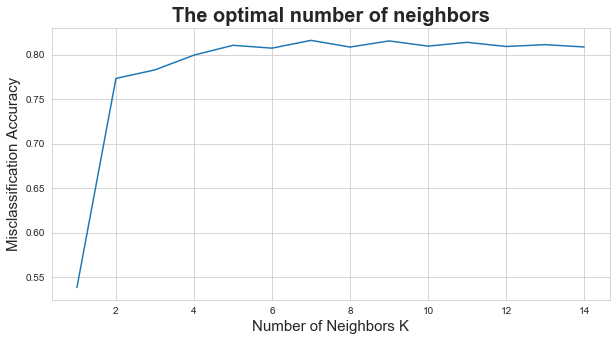

In [84]:
# plot the distribution of the accuracy scores given the different values of K
MSE = [x for x in k_scores]
plt.figure()
plt.figure(figsize=(10,5))
plt.title('The optimal number of neighbors', fontsize=20, fontweight='bold')
plt.xlabel('Number of Neighbors K', fontsize=15)
plt.ylabel('Misclassification Accuracy', fontsize=15)
sns.set_style("whitegrid")
plt.plot(k_range, MSE)
plt.show()

<Figure size 432x288 with 0 Axes>

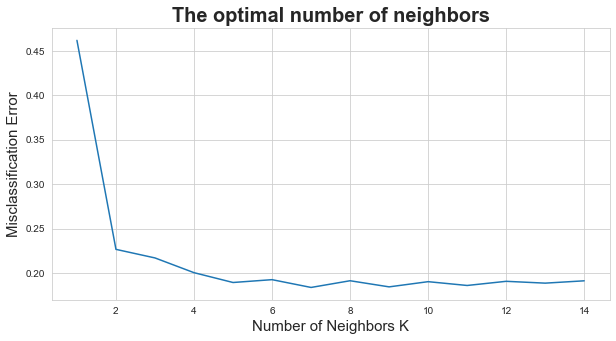

In [86]:
# plot the distribution of the error scores given the different values of K
MSE = [1-x for x in k_scores]
plt.figure()
plt.figure(figsize=(10,5))
plt.title('The optimal number of neighbors', fontsize=20, fontweight='bold')
plt.xlabel('Number of Neighbors K', fontsize=15)
plt.ylabel('Misclassification Error', fontsize=15)
sns.set_style("whitegrid")
plt.plot(k_range, MSE)
plt.show()

# Overall Results Analysis

From running our algorithms, we started by plotting a kind of a classification report and we provided classification reports for the two different preprocessing tasks and they show us different key metrics which are : the support, the precision, the recall and the f1 score, so we’re going to quickly go through each one of them :
* the support simply displays the number of objects of each given class in our test dataset, it means that for instance we have 429 objetcs of class_0, 5757 of class_1 and 1249 of class_2 and that’s why values don’t change when we perform the two different preprocessing tasks because we’re simply performing on the same test dataset. 
However, we can say that our training data is not a really well balanced one since there’s not an equal distribution of data among the three classes, here for instance it’s clear that the class 1 which refers to offensive tweets has more samples than the other two classes
* The precision, on the other side, gives us an idea about the proportions of predictions that are true and correctly classified for each class. So for the first and second preprocessing cases for example and for the KNN algorithm, we can say that more than 80% of the predictions for the two last classes are actually of the predicted class while the rest are actually of the opposite one. However, this is not at all the case for the first class which refers to hateful tweets because only 41% for the first preprocessing and 37 % percent of the predicted samples for the second preprocessing belong to the actual class. 
* When we look at the recall, we can also say that our classifier is correctly identifying 96% of the class 1 which is really good however its missing out the tweets belonging to the two other classes and its only correctly recognizing a small percentage of them.
* And The f1 score is kind of a mean between the precision and recall values.
And finally we came up with an accuracy of 81% for the two preprocessing cases and it seems that all of the metrics values are quietly similar when we performed the two different preprocessing tasks meaning that our results don’t really rely on the preprocessing method we choose.
So to conclude, we can say that the value of our accuracy may be misleading because despite our accuracy value, the model is hardly able to detect the objectfs of the first class and one of the reasons for that may be that our testing set is imbalanced and the fact that there are only few samples of the first class.
And in order to further check the performance of our classifier and how far it can well perform, we have also generated what we call a confusion matrix : a simple tool with two dimensions for evaluating a model performance.
In our case, we have 3 rows and 3 columns each row of the matrix refers to the instances in each of the 3 actual classes and each column refers to the instances in each of the 3 predicted classes.
To make it clearer, we can say that in the example of the KNN confusion matrix using the first preprocessing tasks , out of 429 objects of the first class which refers to hate speech or hateful tweets, only 83 objects of them are actually classified as hateful tweets while the others were being mislabeled.
So here again we can say that the predictions for the first class are not accurate and that our model needs further improvements. 
That’s why, we’ve thought about a way of optimization and varying the K value. The basic idea behind this is to see if varying the value of the neigbors number can have an influence on the accuracy results. And here again, we can see that increasing the value of K and running the algorithm on each value of K does not really affect the performance of our classifier. 
=> All of the results that we came with emphasize the fact that our data is a kind of poor and not weel balanced and that our model needs further ways of improvments if we want to come up with better results.